In [2]:
import pickle
from datetime import datetime as dt
import uuid 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
t = pickle.load( open( "data_set.p", "rb" ) )
t = t.dropna(axis='rows', how='any',subset=['url', 'action'])

 # define time variables
# define time variables
t['start_time'] = t['start_time'].apply(lambda x: dt.strptime(str(x), "%Y-%m-%d %H:%M:%S:%f"))
t['start_time'] = t['start_time'].apply(lambda x: x.replace(microsecond=0))

t['date'] = t['start_time'].dt.date
t['hour'] = t['start_time'].dt.hour
t['DOW'] = t['start_time'].dt.dayofweek

# create new session_id based on load = "new browser session"
# visit_id is not a good measure, since people remain logged in for 1 hour. This was previously 2 hours.
# in the App, people remain logged in for 11 months, so visit_ids could carry on for a long time
# Advice: I would define a session based on inactivity. Create new session after 30 minutes inactivity
t.sort_values(['visit_id', 'start_time'], inplace=True)

t['lag_ts'] = t.sort_values(['visit_id','start_time']).groupby('visit_id')['start_time'].shift(1)
t['lag_ts'].fillna(t['start_time'],inplace=True) # for the first event in session
t['inactivity'] = (t['start_time'] - t['lag_ts']) / np.timedelta64(1, 'm')

cond_inactivity = t.inactivity > 20
cond_load = t.action == '_load_'
cond_homepage = t.url == 'https://www.telenor.no/bedrift/minbedrift/beta/#/'
cond = (cond_load & cond_homepage) | cond_inactivity
t['tmp'] = cond.groupby(t.visit_id).cumsum().where(cond, 0).astype(int).replace(to_replace=0, method='ffill')

t['sequence'] = t.groupby(['tmp', 'visit_id']).cumcount() + 1
t['UUID'] = 1
t.loc[:, "UUID"] = t.groupby(['user', 'tmp', 'visit_id'])['UUID'].transform(lambda g: uuid.uuid4())

# drop all sessions with 1 event (since they are duplicates)
t['uuid_count'] = t.groupby('UUID').UUID.transform('count')
t = t[t.uuid_count > 1]

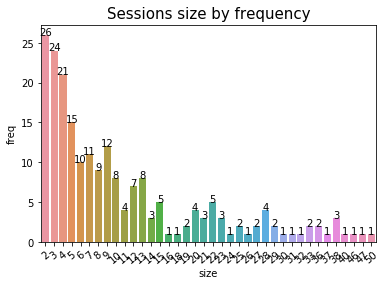

In [4]:
# event subset is last 3000
df = pd.DataFrame({'size':t.groupby('UUID').size()})
freq = pd.DataFrame({'freq':df.groupby('size').size()})
freq['size'] = freq.index
freq['inx'] = range(len(freq))
ax = sns.barplot(x="size", y="freq", data=freq)
ax.set_xticklabels(freq["size"], rotation=40)
for index, row in freq.iterrows():
    ax.text(row.inx, row.freq, row.freq, color='black', ha="center")
plt.title("Sessions size by frequency", fontsize=15)
plt.savefig('img/session_freq.png')

In [89]:
freq

,freq,size,inx
size,,,
1,65,1,0
2,26,2,1
3,24,3,2
4,21,4,3
5,15,5,4
6,10,6,5
7,11,7,6
8,9,8,7
9,12,9,8
